In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import pandas as pd
import time
import scipy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['figure.figsize'] = (8,8)
from sklearn import preprocessing

sns.set_style('white')
pd.set_option('display.max_columns', 35)

## READING IN DATA

In [9]:
print "Starting to read in data..."
t1 = time.time()
requests = pd.read_csv('311__Service_Requests.csv', parse_dates=True)
t2 = time.time()
print "Read in data in %.2f seconds." % (t2 - t1)


Starting to read in data...


//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read in data in 6.41 seconds.


In [10]:
# processing on the data types
print "Starting to process data types..."
t1 = time.time()
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    requests[col] = pd.to_datetime(requests[col], infer_datetime_format=True)
t2= time.time()
print "Dates processed in %.2f seconds." % (t2-t1)

Starting to process data types...
Dates processed in 570.76 seconds.


In [14]:
begin = pd.to_datetime('January 1, 2015 12:01AM')
end = pd.to_datetime('December 31, 2015 11:59PM')

closed_requests = requests[requests['CASE_STATUS'] == 'Closed']
closed_requests = closed_requests[(closed_requests['Source']=='Constituent Call') | (closed_requests['Source']=='Citizens Connect App')]

in_range= closed_requests[closed_requests['OPEN_DT'] > begin]
in_range = in_range[in_range['OPEN_DT'] < end]

times = (in_range['CLOSED_DT'] - in_range['OPEN_DT']).astype('timedelta64[m]')

print "Now standardizing data"
print "The mean response time is %.2f minutes with standard deviation %.2f minutes" % (np.mean(times), 
                                                                                       np.std(times))
print "The mean latitude is %.3f with standard deviation %.3f" % (np.mean(in_range['LATITUDE']), 
                                                                  np.std(in_range['LATITUDE']))
print "The mean longitude is %.3f with standard deviation %.3f" % (np.mean(in_range['LONGITUDE']), 
                                                                   np.std(in_range['LONGITUDE']))

times_scaled = preprocessing.scale(times)
latitude_scaled = preprocessing.scale(in_range['LATITUDE'])
longitude_scaled = preprocessing.scale(in_range['LONGITUDE'])


times_scaled_call = times_scaled[np.where(in_range['Source']=='Constituent Call')]
lat_scaled_call = latitude_scaled[np.where(in_range['Source']=='Constituent Call')]
long_scaled_call = longitude_scaled[np.where(in_range['Source']=='Constituent Call')]

times_scaled_app = times_scaled[np.where(in_range['Source']=='Citizens Connect App')]
lat_scaled_app = latitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]
long_scaled_app = longitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]

appdata = np.stack((times_scaled_app, long_scaled_app, lat_scaled_app), axis = 1)
calldata = np.stack((times_scaled_call,long_scaled_call, lat_scaled_call), axis = 1)

#randomizing the order of the data in order to downsample
np.random.shuffle(appdata)
appdata = appdata[::4]
print appdata.shape #checking size of array
np.random.shuffle(calldata)
calldata = calldata[::10]
print calldata.shape #checking size of array

#save downsampled data into npy format

np.save("appdataforgibbs", appdata)
np.save("calldataforgibbs",calldata)


Now standardizing data
The mean response time is 19020.74 minutes with standard deviation 41847.69 minutes
The mean latitude is 42.326 with standard deviation 0.034
The mean longitude is -71.083 with standard deviation 0.035
(9241, 3)
(10211, 3)


## Plotting Constituent Call and Citizens Connect data

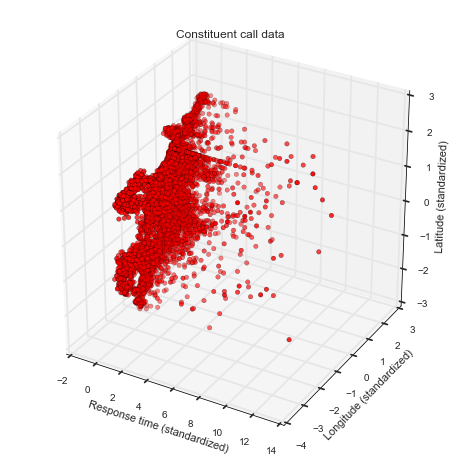

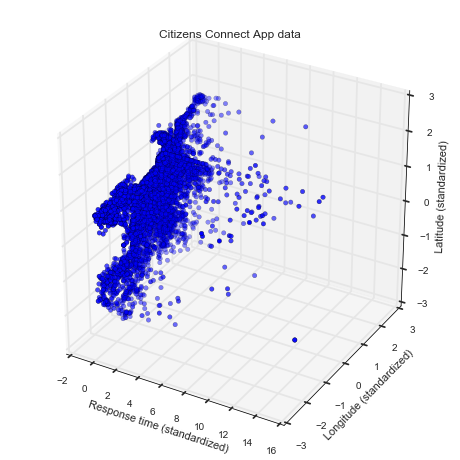

In [47]:

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(calldata[:,0], calldata[:,1], calldata[:,2], c = 'red')
ax.set_xlabel('Response time (standardized)')
ax.set_ylabel('Longitude (standardized)')
ax.set_zlabel('Latitude (standardized)')
ax.set_title('Constituent call data')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(appdata[:,0], appdata[:,1], appdata[:,2], c = 'blue')
ax.set_xlabel('Response time (standardized)')
ax.set_ylabel('Longitude (standardized)')
ax.set_zlabel('Latitude (standardized)')
ax.set_title('Citizens Connect App data')
plt.show()

## Gibbs Sampler

In [18]:
from scipy.stats import invwishart, multivariate_normal, dirichlet

def update_Z(X, mu, Sigma, pi):
    """
    X: NxD matrix
    mu: Vector of k elements. Each element is a vector of D elements. 
    Sigma: Vector of k elements. Each element is a DxD covarianc ematrix
    pi: Vector of k scalars
    Returns Z, an NxK matrix made up of 1s and 0s (each row contains a single 1)
    """
    
    N = len(X)
    K = len(mu)
    Z = np.zeros((N,K))

    probs_vector = np.zeros(K)

    for i in range(N):
        for j in range(K):

            probs_vector[j] = pi[j]*multivariate_normal.pdf(X[i], mean = mu[j], cov = Sigma[j])
        normalization = np.sum(probs_vector)
        probs_vector = probs_vector/normalization
        Z[i] = np.random.multinomial(1, probs_vector)     
    
    return Z


def update_N_k(Z):
    """Returns a k-element vector describing number of elements in each cluster"""
    N_k = np.sum(Z, axis = 0)
    
    return N_k

def update_pi(alpha_k, Z):
    """
    alpha_k: Vector of K scalars
    Z: an NxK matrix
    pi: a vector of K scalars
    """
    N_k = np.sum(Z, axis = 0)
    pi = dirichlet.rvs(alpha_k+N_k)
    #specify that pi has to be in decreasing order
    while np.any(np.diff(pi)>0):
        pi = dirichlet.rvs(alpha_k+N_k)    
    return np.squeeze(pi)

def update_mean_x_k(Z, X, N_k):
    """
    Average value of observations belonging to cluster k
    mean_x_k: Matrix of dimension KxD
    """
    mean_x_k = np.zeros((len(N_k),len(X[0])))
    for i in range(len(mean_x_k)):
        for j in range(len(Z)):
            mean_x_k[i]+=Z[j][i]*X[j]
        mean_x_k[i] = mean_x_k[i]/N_k[i]

    
    return mean_x_k


def update_nu_k(nu_0, N_k):
    """
    returns a k-element vector
    """

    nu_k = nu_0+N_k

    return nu_k



def update_V_k(V_0, N_k, Sigma_k):
    """
    V_0: DxD matrix
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    """
    V_k = np.zeros_like(Sigma_k)
    V_0_inv = np.linalg.inv(V_0)
    for i in range(len(V_k)):
        inv = V_0_inv+N_k[i]*np.linalg.inv(Sigma_k[i])
        V_k[i] = np.linalg.inv(inv)             
        
    return V_k
    
def update_m_k(V_k, Sigma_k, N_k, mean_x_k, V_0, m_0):
    """
    V_0: DxD matrix
    m_0: Vector of K elements, each element has D elements
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mean_x_k: DxK matrix describing average values of observations in each cluster
    """
    V_0_inv = np.linalg.inv(V_0)
    m_k = np.zeros((len(N_k), len(m_0)))
    for i in range(len(m_k)):
        Sig_inv = np.linalg.inv(Sigma_k[i])

        m_k[i] = np.dot(V_k[i],(np.dot(Sig_inv,N_k[i]*mean_x_k[i])+np.dot(V_0_inv,m_0)))
    return m_k

def update_mu_k(m_k, V_k):
    """
    m_k: Vector of k elements, each element has a vector with D elements
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mu_k: Vector of k elements, each element has a vector with D elements
    """
    mu_k = np.zeros_like(m_k)

    for i in range(len(mu_k)):
        mu_k[i] = multivariate_normal.rvs(mean = m_k[i], cov = V_k[i])

    return mu_k

def update_S_k(Z, X, mu_k, S_0):
    """
    S_0: DxD matrix
    Scale matrices for inverse wishart distribution
    Returns array of k matrices (DxD)
    """
    S_k = np.zeros((len(mu_k), S_0.shape[0], S_0.shape[1]))
    for j in range(len(mu_k)):
        S_k[j]=np.copy(S_0)
        for i in range(len(Z)):
            S_k[j]+=Z[i][j]*np.outer((X[i]-mu_k[j]),(X[i]-mu_k[j]))
    return S_k

def update_Sigma_k(S_k, nu_k):
    """
    Covariance matrices for the k clusters
    Returns array of k matrices of dimension DxD
    """
    Sigma_k = np.zeros_like(S_k)
    for i in range(len(nu_k)):
        Sigma_k[i] = invwishart.rvs(nu_k[i], S_k[i])
    return Sigma_k

def gibbs_gmm(K, X, pi, mu, Sigma, nu_0, S_0, V_0, m_0, alpha_0):
    """
    K: number of components
    X: observations
    nu_0: dof for inverse Wishart distribution
    S_0: scale matrix for inverse Wishart distribution
    m_0: Mean of normal-inverse-Wishart distribution
    V_0: Covariance matrix of normal-inverse-Wishart distribution
    alpha_0: parameter for Dirichlet distribution
    """
    numsamples = 500
    start = time.time()
    Z_samples = np.zeros((numsamples, X.shape[0], pi.shape[0]))
    mu_samples = np.zeros((numsamples, mu.shape[0], mu.shape[1]))
    pi_samples = np.zeros((numsamples, K))
    Sigma_samples = np.zeros((numsamples, K, Sigma.shape[1], Sigma.shape[2]))
    nu_samples = np.zeros((numsamples, K))
    V_samples = np.zeros((numsamples, K, V_0.shape[0],V_0.shape[1]))
    m_samples = np.zeros((numsamples, K, m_0.shape[0]))
    S_samples = np.zeros_like(Sigma_samples)

    Z_samples[0] = update_Z(X, mu, Sigma, pi)
    N_k = update_N_k(Z_samples[0])
    pi_samples[0] = pi
    mean_x_k = update_mean_x_k(Z_samples[0], X, N_k)
    mu_samples[0] = mu
    Sigma_samples[0] = Sigma
    nu_samples[0] = update_nu_k(nu_0, N_k)
    V_samples[0] = update_V_k(V_0, N_k, Sigma_samples[0])
    m_samples[0] = update_m_k(V_samples[0], Sigma_samples[0], N_k, mean_x_k, V_0, m_0)
    S_samples[0] = update_S_k(Z_samples[0], X, mu_samples[0], S_0)

    for i in range(1,numsamples):
    
        Z_samples[i]= update_Z(X, mu_samples[i-1], Sigma_samples[i-1], pi_samples[i-1])
        N_k = update_N_k(Z_samples[i])
        if i%50==0:
            print i, time.time()-start
        pi_samples[i] = update_pi(alpha_0, Z_samples[i])
        mean_x_k = update_mean_x_k(Z_samples[i], X, N_k)
        mu_samples[i] = update_mu_k(m_samples[i-1], V_samples[i-1])
        Sigma_samples[i] = update_Sigma_k(S_samples[i-1], nu_samples[i-1])
        nu_samples[i] = update_nu_k(nu_0, N_k)
        V_samples[i]= update_V_k(V_0, N_k, Sigma_samples[i])
        m_samples[i] = update_m_k(V_samples[i], Sigma_samples[i], N_k, mean_x_k, V_0, m_0)
        S_samples[i] = update_S_k(Z_samples[i], X, mu_samples[i], S_0)

    return Z_samples, pi_samples, mu_samples, Sigma_samples, nu_samples, V_samples, m_samples, S_samples




## Sampling the posterior for call data

In [19]:
#call data fitting
K = 3

#initializing with MAP results

pi = np.array([ 0.85561417, 0.13795177, 0.00643406])

#note that variables are in order: response time, longitude, latitude
Sigma = np.array([[[ 0.109255, 0.00936383, -0.00547017], 
                   [0.00936383, 1.12566872, 0.55098458], 
                   [-0.00547017, 0.55098458, 1.22771629]], 
                 [[ 1.92483963, 0.06452807, 0.0097768 ], 
                  [ 0.06452807,  1.28456653,  0.29894916],
                  [ 0.0097768,   0.29894916,  1.28388214]],
                 [[ 10.56069314, 0.4418922, 0.16616875], 
                  [0.4418922, 8.54962789,0.88448615],
                  [0.16616875, 0.88448615, 8.52842064]]])

mu = np.array([[ -2.85596910e-01,  -8.06180353e-02,  -2.30132447e-01], 
               [  1.44914839e+00,   5.81729345e-03,  -1.00870066e-01],
               [  7.00437911e+00,  -1.35817042e-01,  -1.67447475e-01]])
nu_0 = 3
S_0 = np.eye(3)
V_0 =  np.eye(3)
m_0 = np.array([1., 1., 1.])  
alpha_0 = np.array([1., 1., 1.])



Z_samples_c3, pi_samples_c3, mu_samples_c3, Sigma_samples_c3, nu_samples_c3, V_samples_c3, m_samples_c3, S_samples_c3= gibbs_gmm(K, 
                                                                                                         calldata, 
                                                                                                         pi,  
                                                                                                         mu, 
                                                                                                         Sigma, 
                                                                                                         nu_0, 
                                                                                                         S_0, 
                                                                                                         V_0, 
                                                                                                         m_0, 
                                                                                                         alpha_0)

50 161.544987917
100 320.633579016
150 477.142791986
200 636.278964043
250 796.517100096
300 952.516191959
350 1301.68565893
400 1741.04057407
450 1901.80416894


In [35]:
#save results of sample as backup
np.savez("calldatasamples.npz", Z = Z_samples_c3, pi = pi_samples_c3 , 
         mu = mu_samples_c3, Sigma  = Sigma_samples_c3, nu = nu_samples_c3,   
          V = V_samples_c3,  m =  m_samples_c3, S = S_samples_c3)

## Sampling posterior for app data

In [145]:
#app data fitting
K = 3

#initializing with MAP results

pi = np.array([0.83150555, 0.16061821, 0.00787624])

#note that variables are in order: response time, longitude, latitude
Sigma = np.array([[[ 0.1088711, -0.00862437, -0.00486507],
                   [-0.00862437, 0.96755996, 0.32477091],
                   [-0.00486507, 0.32477091, 0.79889581]], 
                  [[1.43729609, 0.16179275, 0.05837291],
                   [0.16179275, 1.36653982, 0.26216304],
                   [0.05837291, 0.26216304,1.07216398]],
                  [[11.86861284, 0.47086945, 0.20433425],
                   [0.47086945, 7.49374592, 0.58237359],
                   [0.20433425, 0.58237359, 7.50062468]]])

mu = np.array([[-0.32005411, 0.10147857, 0.23575437],
               [1.28475424, -0.04635469, 0.23087891],
               [7.34751927, -0.08100497,  0.11962156]])
nu_0 = 3
S_0 = np.eye(3)
V_0 =  np.eye(3)
m_0 = np.array([1., 1., 1.])  
alpha_0 = np.array([1., 1., 1.])



Z_samples_a3, pi_samples_a3, mu_samples_a3, Sigma_samples_a3, nu_samples_a3, V_samples_a3, m_samples_a3, S_samples_a3= gibbs_gmm(K, 
                                                                                                         appdata, 
                                                                                                         pi,  
                                                                                                         mu, 
                                                                                                         Sigma, 
                                                                                                         nu_0, 
                                                                                                         S_0, 
                                                                                                         V_0, 
                                                                                                         m_0, 
                                                                                                         alpha_0)

50 152.704195976
100 305.987414837
150 462.948587894
200 619.873004913
250 773.433478832
300 925.615272045
350 1066.33237982
400 1207.73044395
450 1351.31167603


In [146]:
#save results of sample as backup
np.savez("appdatasamples.npz", Z = Z_samples_a3, pi = pi_samples_a3 , 
         mu = mu_samples_a3, Sigma  = Sigma_samples_a3, nu = nu_samples_a3,   
          V = V_samples_a3,  m =  m_samples_a3, S = S_samples_a3)

## Posterior analysis

In [261]:
def get_mu_posterior(mu_samples, K, burnin):
    mu_avg = np.zeros_like(mu_samples[0])
    mu_std = np.zeros_like(mu_samples[0])
    for i in range(K):
        mu_avg[i] = np.mean(mu_samples[burnin:,i], axis = 0)
        mu_std[i] = np.std(mu_samples[burnin:,i], axis = 0)
    return mu_avg, mu_std

def get_pi_posterior(pi_samples, burnin):
    return np.mean(pi_samples[burnin:],axis = 0), np.std(pi_samples[burnin:], axis = 0)

def get_Sigma_posterior(Sigma_samples, burnin):
    return np.mean(Sigma_samples[burnin:],axis = 0), np.std(Sigma_samples[burnin:], axis = 0)

colors = ('#0096b2', '#63ffc4', '#ff7500')
def plot_mu_trace(mu_samples, K, title):
    f, ax = plt.subplots(3,3,figsize = (16,8), sharex = True)
    f.suptitle(title)
    for i in range(K):
        for j in range(mu_samples.shape[2]):
            ax[j,i].plot(mu_samples[:,i, j], color = colors[i])
    ax[0,0].set_ylabel("Response time (standardized)")
    ax[1,0].set_ylabel('Long. (normalized)')
    ax[2,0].set_ylabel("Lat. (normalized)")
    ax[0,2].set_xlabel('Iteration number')
    ax[0,0].annotate('Cluster 1', xycoords = 'axes fraction', xy = (0.75, 0.75))
    ax[0,1].annotate('Cluster 2', xycoords = 'axes fraction', xy = (0.75, 0.75))
    ax[0,2].annotate('Cluster 3', xycoords = 'axes fraction', xy = (0.75, 0.75))
                
    plt.show()
    
def plot_pi_trace(pi_samples, K, title):
    plt.figure(figsize = (6,6))
    for i in range(K):
        plt.plot(pi_samples[:,i], color=colors[i], label = "Cluster %d"  % (i+1,))
    plt.title(title)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of observations')
    plt.show()
    
def print_point_est(mu_samples, pi_samples, Sigma_samples,K, burnin):
    mu_avg, mu_std = get_mu_posterior(mu_samples, K, burnin)
    pi_avg, pi_std = get_pi_posterior(pi_samples, burnin)
    Sigma_avg, Sigma_std = get_Sigma_posterior(Sigma_samples, burnin)
    print "The variables are in order of response time, longitude, and latitude (standardized)"
    print "The posterior means for the cluster centers are:"
    for i in range(K):
        print
        print "Cluster %d" % (i+1,)
        print
        print pd.DataFrame(data = mu_avg[i], 
                       index = ('Response time', "Long.", "Lat."), 
                       columns  = ("Cluster center mean",))
        print
        print "with corresponding uncertainties"
        print
        print pd.DataFrame(data = mu_std[i], 
                       index = ('Response time', "Long.", "Lat."), 
                       columns  = ("Cluster center uncertainty",))
        
    print
    print "The posterior mean cluster fractions are"
    print pd.DataFrame(data = pi_avg, 
                       index = ('Cluster 1', "Cluster 2", "Cluster 3"), 
                       columns  = ("Mean fraction",))
    print "with corresponding uncertainties"
    print pd.DataFrame(data = pi_std, 
                       index = ('Cluster 1', "Cluster 2", "Cluster 3"), 
                       columns  = ("Fraction uncertainty",))
    print 
    print "The posterior cluster covariance matrices are"
    for i in range(K):
        print
        print "Cluster %d" % (i+1,)
        print 
        print pd.DataFrame(data = Sigma_avg[i], 
                           index = ('Response', 'Long.', 'Lat.'),
                          columns = ('Response', 'Long.', 'Lat.'))
        print 
        print "with corresponding uncertainties"
        print pd.DataFrame(data = Sigma_std[i],
                          index = ('Response', 'Long.', 'Lat.'),
                          columns = ('Response', 'Long.', 'Lat.'))
        
def plot_cluster_assignments(Z_samples, burnin, data, title):
    labelmode, count = scipy.stats.mstats.mode(Z_samples[burnin:])
    labelmode = np.squeeze(labelmode)
    cluster1 = data[np.where(labelmode[:,0]==1)]
    cluster2 = data[np.where(labelmode[:,1]==1)]
    cluster3 = data[np.where(labelmode[:,2]==1)]
    fig = plt.figure()
    ax = fig.add_subplot(111,projection = '3d')
    ax.scatter(cluster1[:,0], cluster1[:,1], cluster1[:,2], c = colors[0])
    ax.scatter(cluster2[:,0], cluster2[:,1], cluster2[:,2], c = colors[1])
    ax.scatter(cluster3[:,0], cluster3[:,1], cluster3[:,2], c = colors[2])
    ax.set_xlabel('Response time (standardized)')
    ax.set_ylabel('Longitude (standardized)')
    ax.set_zlabel('Latitude (standardized)')
    ax.set_title(title)
    plt.show()
        
def posterior_predictive(pi_samples, mu_samples, Sigma_samples, burnin, title):
    pi_posterior = pi_samples[burnin:]
    mu_posterior = mu_samples[burnin:]
    Sigma_posterior = Sigma_samples[burnin:]
    K = 3
    samplesize = 10000
    labels = np.zeros((samplesize, K))
    predicted_vals = np.zeros((samplesize, 3))
    #draw from posteriors
    draw = np.random.randint(low = 0, high = len(pi_posterior)+1)
    pi_draw = pi_posterior[draw]
    mu_draw = mu_posterior[draw]
    Sigma_draw = Sigma_posterior[draw]
    #now sample from likelihood
    #first, determine which cluster the randomly drawn point belongs to 
    for i in range(samplesize):
        r = np.random.uniform()
        if r < pi_draw[0]:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[0], cov = Sigma_draw[0])
            labels[i] = np.array([1,0,0])
        elif r > 1-pi_draw[2]:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[2], cov = Sigma_draw[2])
            labels[i] = np.array([0,0,1])
        else:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[1], cov = Sigma_draw[1])
            labels[i] = np.array([0,1,0])
            
    cluster1 = predicted_vals[np.where(labels[:,0]==1)]
    cluster2 = predicted_vals[np.where(labels[:,1]==1)]
    cluster3 = predicted_vals[np.where(labels[:,2]==1)]
    fig = plt.figure(figsize = (24,24))
    ax = fig.add_subplot(111,projection = '3d')
    ax.scatter(cluster1[:,0], cluster1[:,1], cluster1[:,2], c = colors[0])
    ax.scatter(cluster2[:,0], cluster2[:,1], cluster2[:,2], c = colors[1])
    ax.scatter(cluster3[:,0], cluster3[:,1], cluster3[:,2], c = colors[2])
    plt.setp(ax.get_xticklabels(), fontsize = 24)
    plt.setp(ax.get_yticklabels(), fontsize = 24)
    plt.setp(ax.get_zticklabels(), fontsize = 24)
    ax.set_xlabel('Response time (standardized)', size = 24, labelpad = 30)
    ax.set_ylabel('Longitude (standardized)', size = 24, labelpad =30)
    ax.set_zlabel('Latitude (standardized)', size = 24, labelpad = 30)
    ax.set_title(title, size = 24)
    plt.show()





### Traces for call data 

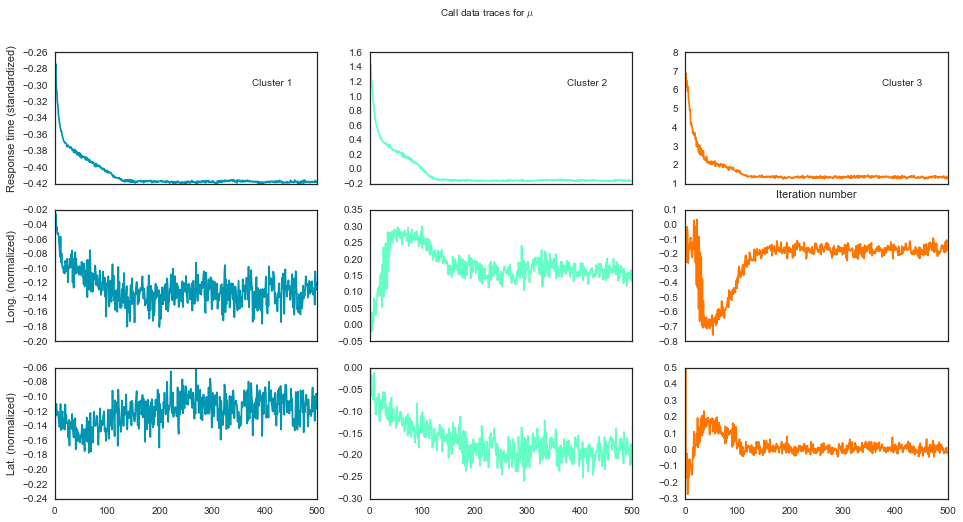

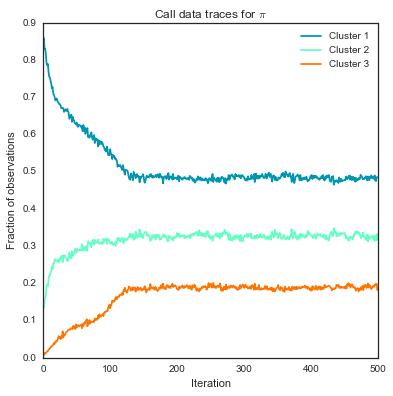

In [121]:
plot_mu_trace(mu_samples_c3, K, "Call data traces for $\mu$")
plot_pi_trace(pi_samples_c3, K, "Call data traces for $\pi$")


### Point estimates for call data

In [120]:
print_point_est(mu_samples_c3, pi_samples_c3, Sigma_samples_c3, K, 150)

The variables are in order of response time, longitude, and latitude (standardized)
The posterior means for the cluster centers are:

Cluster 1

               Cluster center mean
Response time            -0.417602
Long.                    -0.133749
Lat.                     -0.113354

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.000962
Long.                            0.015891
Lat.                             0.017406

Cluster 2

               Cluster center mean
Response time            -0.156258
Long.                     0.165866
Lat.                     -0.187727

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.005972
Long.                            0.021567
Lat.                             0.024099

Cluster 3

               Cluster center mean
Response time             1.351716
Long.                    -0.172865
Lat.                      0.006499

with

### Traces for app data

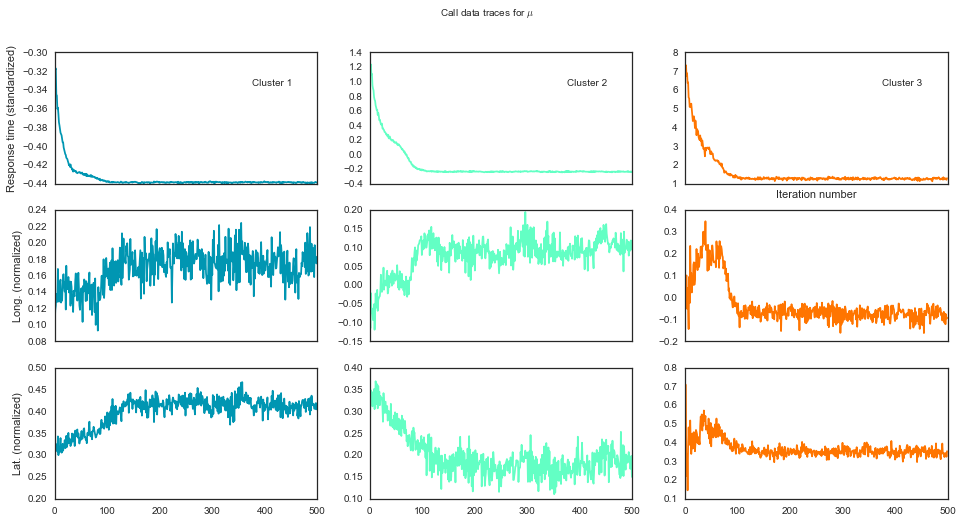

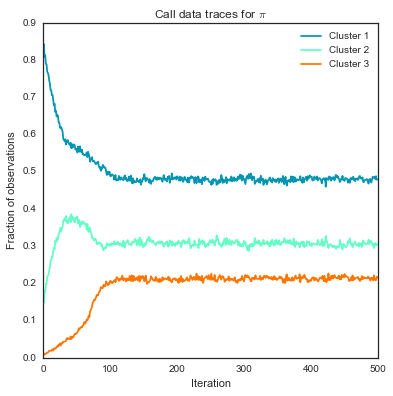

In [147]:
plot_mu_trace(mu_samples_a3, K, "Call data traces for $\mu$")
plot_pi_trace(pi_samples_a3, K, "Call data traces for $\pi$")

### Point estimates from posterior for app data

In [148]:
print_point_est(mu_samples_a3, pi_samples_a3, Sigma_samples_a3, K, 150)

The variables are in order of response time, longitude, and latitude (standardized)
The posterior means for the cluster centers are:

Cluster 1

               Cluster center mean
Response time            -0.438603
Long.                     0.176566
Lat.                      0.415617

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.000442
Long.                            0.017472
Lat.                             0.015403

Cluster 2

               Cluster center mean
Response time            -0.234840
Long.                     0.095565
Lat.                      0.176607

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.004319
Long.                            0.027541
Lat.                             0.025978

Cluster 3

               Cluster center mean
Response time             1.267452
Long.                    -0.074500
Lat.                      0.349923

with

### Cluster assignments based on posterior samples

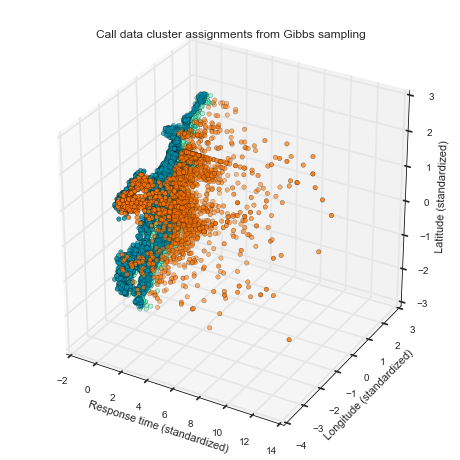

In [126]:
plot_cluster_assignments(Z_samples_c3, burnin, calldata, title = 'Call data cluster assignments from Gibbs sampling')

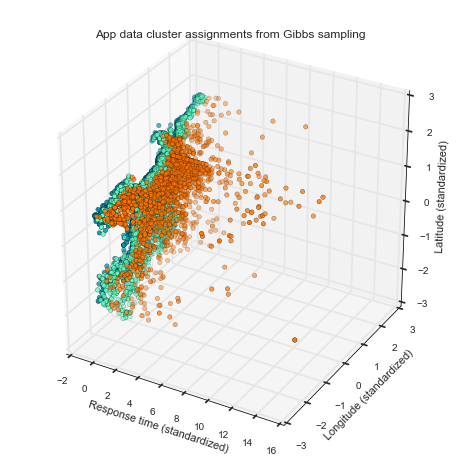

In [151]:
plot_cluster_assignments(Z_samples_a3, burnin, appdata, title = 'App data cluster assignments from Gibbs sampling')

### Posterior predictive distributions

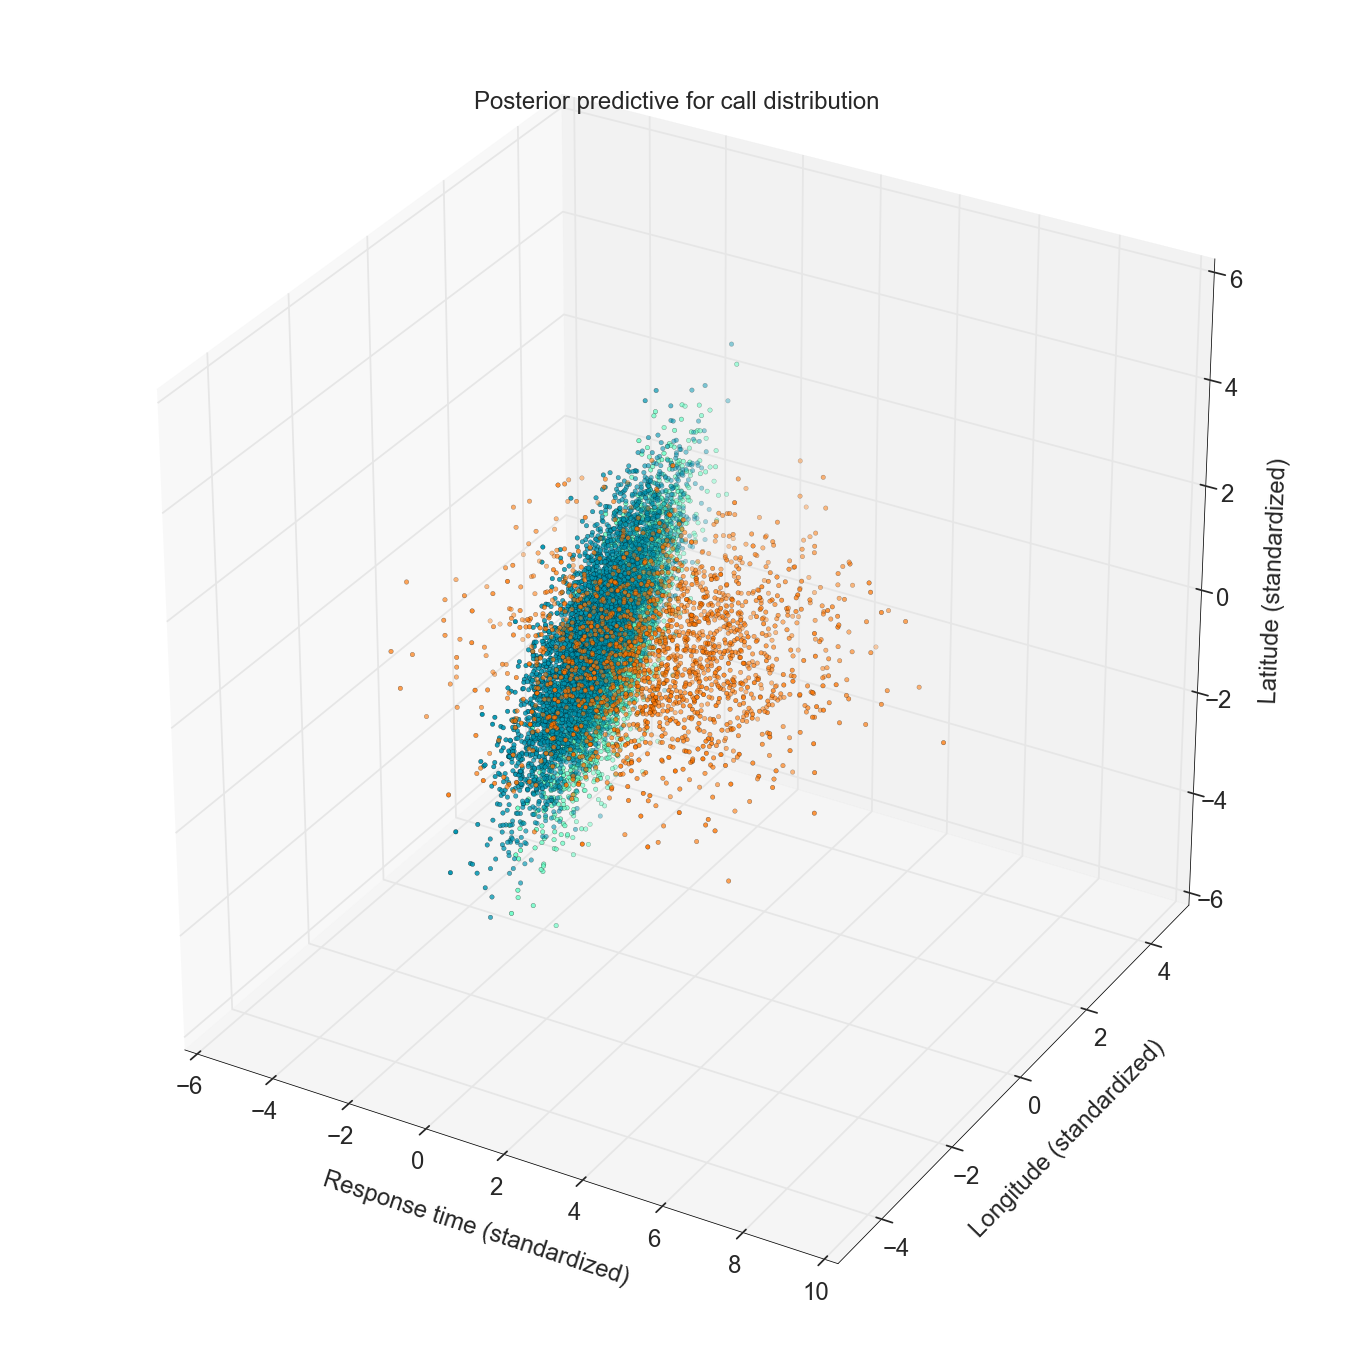

In [262]:
posterior_predictive(pi_samples_c3, mu_samples_c3, 
                     Sigma_samples_c3, 150,"Posterior predictive for call distribution")

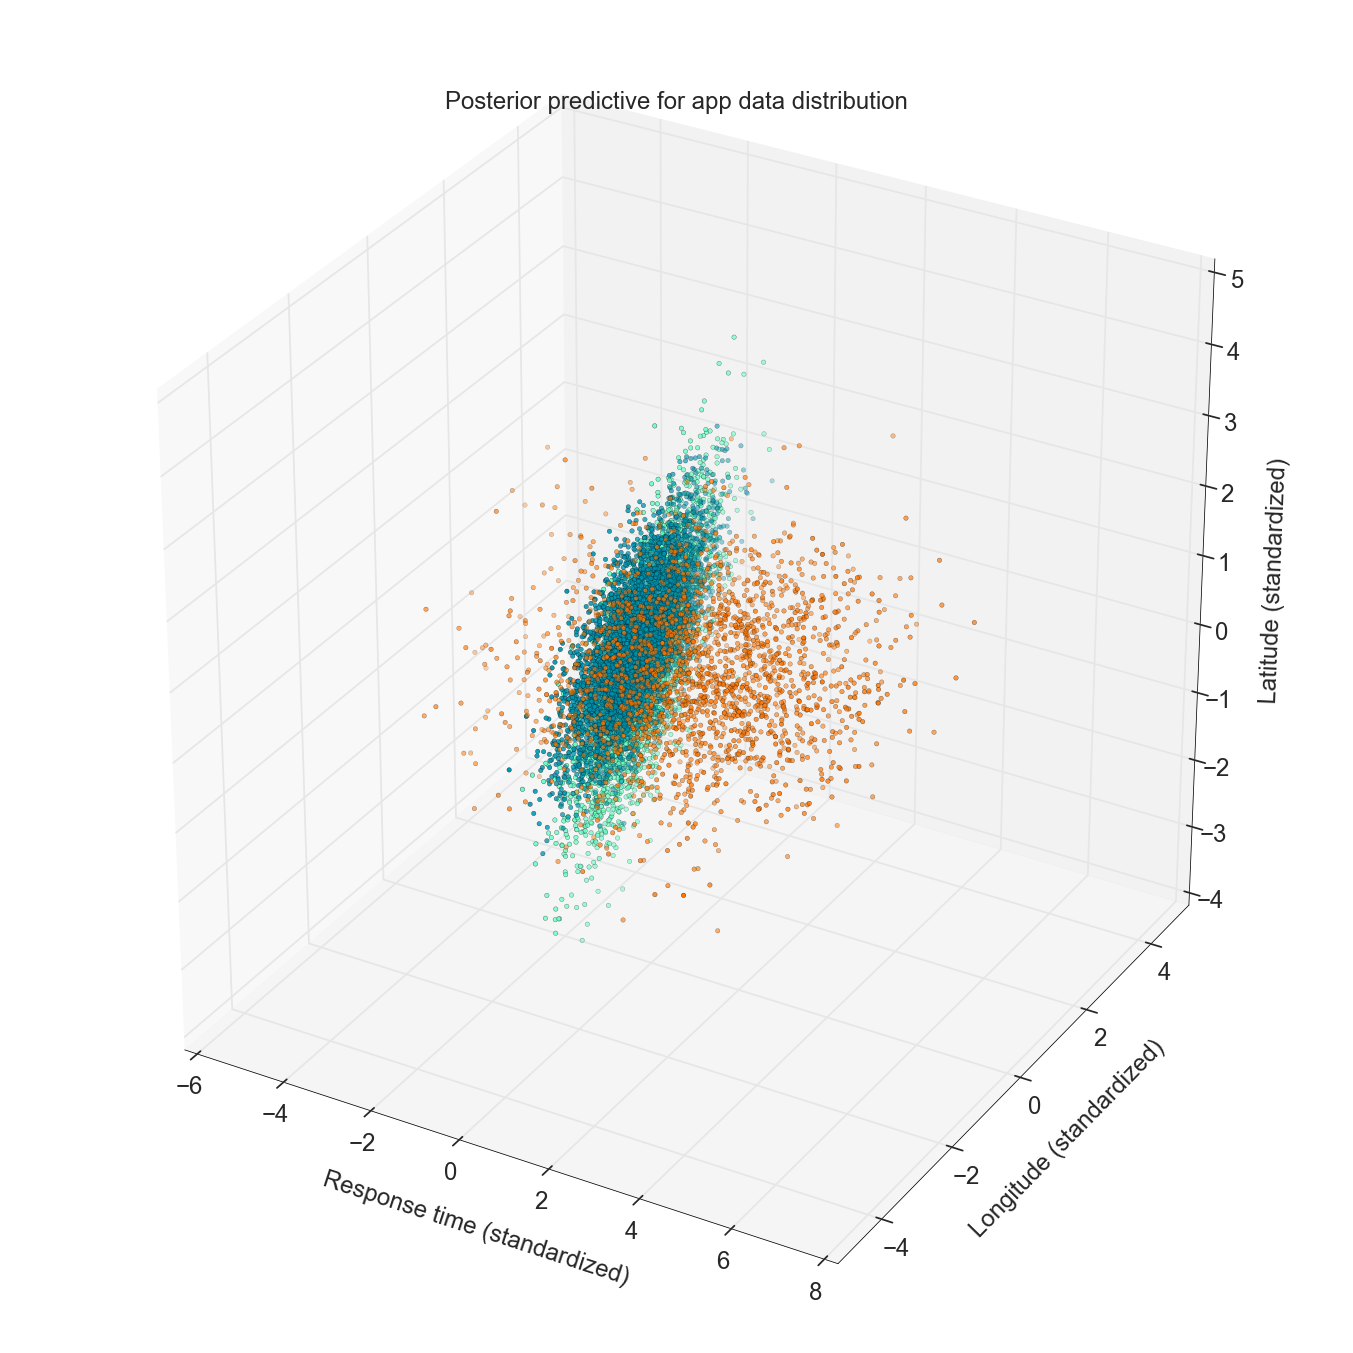

In [263]:
posterior_predictive(pi_samples_a3, mu_samples_a3, 
                     Sigma_samples_a3, 150,"Posterior predictive for app data distribution")

## DON'T FORGET TO ADD FUNCTIONS FOR PLOTTING POSTERIOR HISTOGRAMS

In [222]:
import pymc as pm
from pymc.distributions import mv_normal_like
appdatasaved = np.load("appdataforgibbs.npy")

In [237]:
K = 3
M = 3
N = len(data)

#-------------   model parameters
alpha = np.array(np.ones(K)) #shape parameter 
nu = K #degrees of freedom (greater than K - 1)
W = np.eye(M) #scale matrix (positive)
beta = 1. #scale for wishart-normal dist
eta = np.array([0]*M ) #mean for wishart-normal dist

#-------------   priors
#mixture coefficient
pi = pm.CompletedDirichlet('pi', pm.Dirichlet('PI', theta=alpha)) 
#precision matrices
L = pm.Container([pm.Wishart("L_%d" % i, n = nu, Tau = W) for i in range(K)])
    
#means
center = pm.Container([pm.MvNormal("mu_%d" % i, mu=eta, tau=beta*L[i]) for i in range(K)])
      
#latent component memembership
Z = pm.Categorical('Z', p=pi, size=N)
    
@pm.stochastic(observed = True)
def results(value = data, labels = Z, means = center, precision = L):
    logprob = 0
    for i in range(N):
        cluster = labels[i]
        logprob+=mv_normal_like(value[i], mu=means[cluster], tau = precision[cluster])
    return logprob

#-------------   sampling parameters
iters = 10000
burnin = 5000
#-------------   pymc sampler
mc = pm.MCMC([pi, center, L, Z, results])
mc.sample(iter=iters, burn=burnin, thin = 2)


 [-----------------100%-----------------] 10001 of 10000 complete in 1144.9 sec

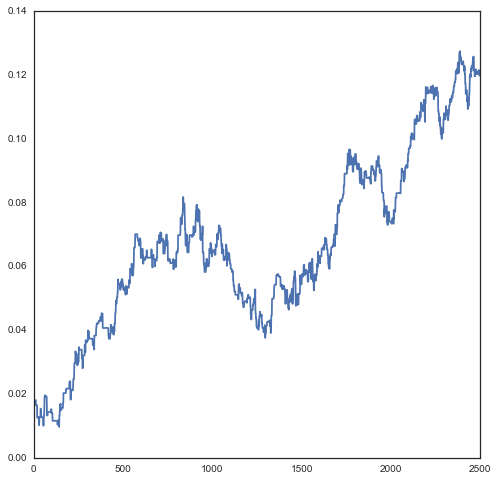

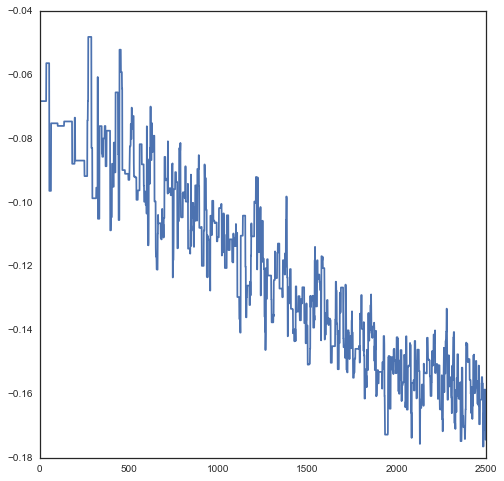

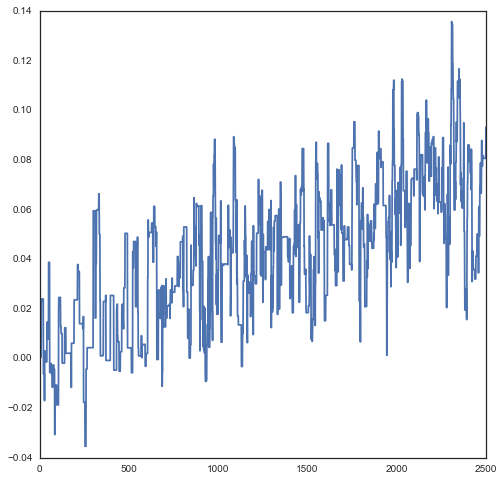

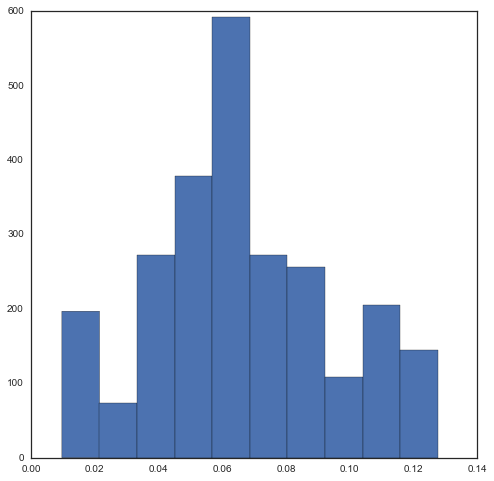

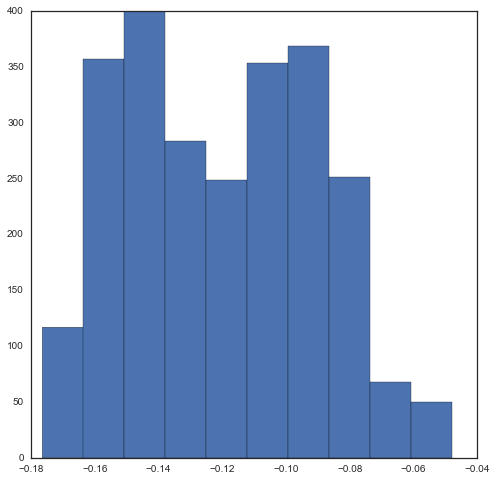

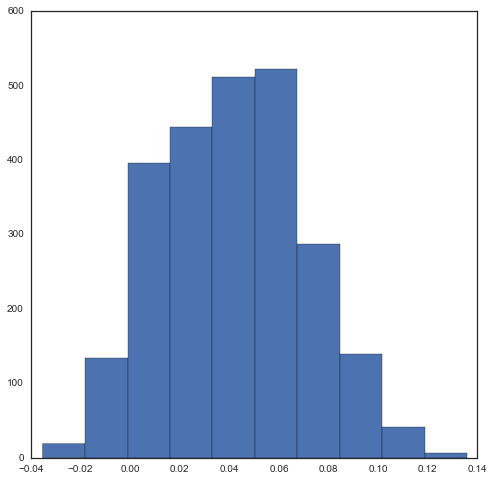

0.0663319211867
-0.119589363861
0.0413731457779


In [238]:
trace1 = mc.trace('mu_0')[:,0]
trace2 = mc.trace('mu_1')[:,0]
trace3 = mc.trace('mu_2')[:,0]
pi_trace = mc.trace('pi')[:]
plt.plot(trace1)
plt.show()

plt.plot(trace2)
plt.show()

plt.plot(trace3)
plt.show()

plt.hist(trace1)
plt.show()
plt.hist(trace2)
plt.show()
plt.hist(trace3)
plt.show()

print np.mean(trace1)
print np.mean(trace2)
print np.mean(trace3)

In [244]:
whos

Variable                   Type                       Data/Info
---------------------------------------------------------------
Axes3D                     type                       <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>
K                          int                        3
L                          ListContainer              [<pymc.distributions.Wish<...>rt 'L_2' at 0x12c1b5550>]
M                          int                        3
N                          int                        9241
S_0                        ndarray                    3x3: 9 elems, type `float64`, 72 bytes
S_samples_a3               ndarray                    500x3x3x3: 13500 elems, type `float64`, 108000 bytes (105 kb)
S_samples_c3               ndarray                    500x3x3x3: 13500 elems, type `float64`, 108000 bytes (105 kb)
Sigma                      ndarray                    3x3x3: 27 elems, type `float64`, 216 bytes
Sigma_avg_c3               ndarray                    3x3x3: 27 elems,